In [1]:
import os
from matrix_client.api import MatrixHttpApi
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matrixstats import *

In [2]:
with open(".matrix_token") as f:
    token = str(f.read()).strip()

homeserver = "https://matrix.cadair.com"
stop_time = "2019/01/01"

api = MatrixHttpApi(homeserver, token=token)

In [3]:
ids = {'matrix': get_rooms_in_community(api, "+matrix:matrix.org")}

In [4]:
events, messages = load_messages(api, ids, refresh_cache=False, stop_time=stop_time)

/opt/miniconda/envs/matrix/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/miniconda/envs/matrix/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
# We ignore emtpy rooms
non_empty_messages = {group: {room: m for room, m in gmessages.items() if not m.empty}
                      for group, gmessages in messages.items()}
all_messages = {group: pd.concat(gmessages).reset_index(level=0)
                for group, gmessages in non_empty_messages.items()}

# Number of Channels

In [6]:
for group, df in messages.items():
    print(group, len(df))

matrix 14


# Number of Messages per Channel

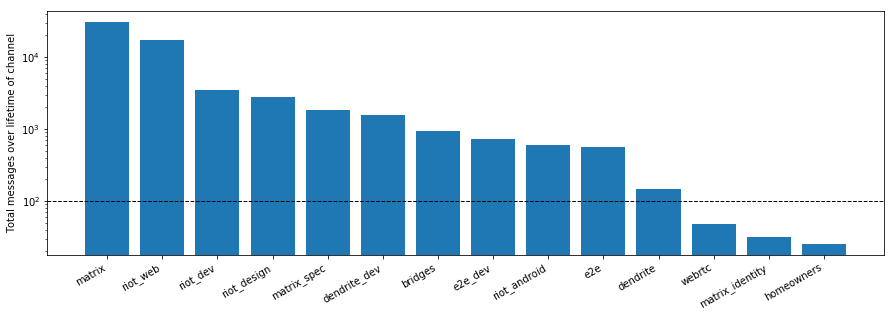

In [7]:
fig = plt.figure(figsize=(15,5))
n_messages = get_len_key(flatten_dicts(messages))
plt.bar(list(range(len(n_messages))), list(n_messages.values()), tick_label=list(n_messages.keys()))
fig.autofmt_xdate()
plt.axhline(100, linestyle="--", linewidth=1, color="k")
plt.semilogy()
_ = plt.ylabel("Total messages over lifetime of channel")

In [8]:
print_sorted_len(flatten_dicts(messages))

matrix: 30695
riot_web: 17293
riot_dev: 3507
riot_design: 2755
matrix_spec: 1841
dendrite_dev: 1562
bridges: 937
e2e_dev: 719
riot_android: 599
e2e: 570
dendrite: 147
webrtc: 48
matrix_identity: 32
homeowners: 25


In [9]:
channel_creation = {k:v.index[-1] for k, v in flatten_dicts(events).items()}

print_sorted_value(channel_creation, reverse=False)

dendrite: 2018-02-03 20:33:05.533000
dendrite_dev: 2018-08-26 11:55:10.712000
e2e_dev: 2018-11-09 10:13:40.730000
webrtc: 2018-11-14 15:28:02.631000
riot_dev: 2018-12-10 14:54:20.338000
bridges: 2018-12-16 15:43:05.975000
riot_web: 2018-12-20 21:46:56.239000
matrix: 2018-12-28 15:12:18.648000
homeowners: 2019-01-01 18:27:38.228000
matrix_spec: 2019-01-11 02:22:18.611000
riot_design: 2019-01-16 09:15:11.409000
e2e: 2019-02-14 18:37:20.069000
matrix_identity: 2019-02-15 01:00:52.800000
riot_android: 2019-03-22 11:39:30.160000


In [10]:
messages_per_day = {group: pd.DataFrame({k:m['body'].resample("1D").count() for k,m in gm.items() if not m.empty})
                    for group, gm in messages.items()}

In [11]:
messages_per_week = {group: pd.DataFrame({k:m['body'].resample("1W").count() for k,m in gm.items() if not m.empty})
                     for group, gm in messages.items()}

In [12]:
total_mpd = {group: df.sum(axis=1) for group, df in messages_per_day.items()}
total_mpw = {group: df.sum(axis=1) for group, df in messages_per_week.items()}

## Total Messages per Week

[699384.35, 738954.65, -372.55, 7823.55]


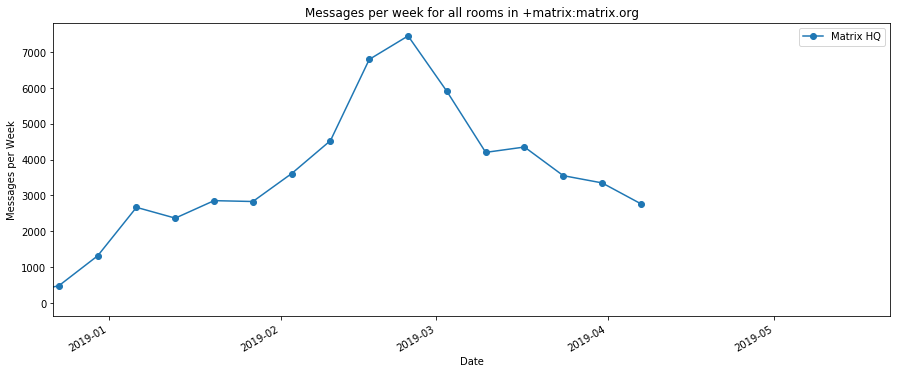

In [13]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(total_mpw['matrix'].index, total_mpw['matrix'], "-o", label="Matrix HQ")
fig.autofmt_xdate()
plt.legend()
ax.set_ylabel("Messages per Week")
ax.set_xlabel("Date")
lims = list(ax.axis())
print(lims)
lims[0] = 737050
lims[1] = 737201
ax.axis(lims)
ax.set_title("Messages per week for all rooms in +matrix:matrix.org")
None

[699380.25, 738952.75, -77.05000000000001, 1618.05]


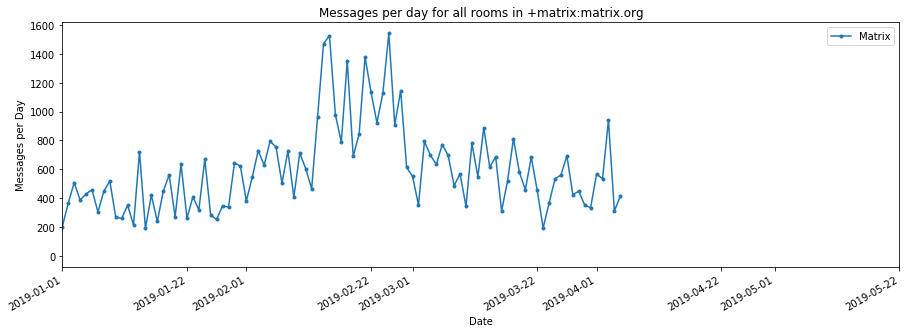

In [14]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Messages per day for all rooms in +matrix:matrix.org")

ax.plot(total_mpd['matrix'].index, total_mpd['matrix'], "-o",
        ms=3, label="Matrix")

fig.autofmt_xdate()
plt.legend()

ax.set_ylabel("Messages per Day")
ax.set_xlabel("Date")
lims = list(ax.axis())
print(lims)
lims[0] = 737060
lims[1] = 737201
ax.axis(lims)
None

In [15]:
all_senders = {}
for group, gmessages in all_messages.items():
    senders = pd.DataFrame(gmessages.groupby("usender").count()['body'].sort_values(ascending=False))
    all_senders[group] = senders

# Message length by sender 

In [16]:
active_senders = calculate_active_senders(api, all_messages, top_n=20)

In [18]:
active_senders['matrix'].iloc[:, 1:]

,number_of_messages,mean_body_len,median_body_len
display_name,,,
tulir*,3733,89.199839,71.0
Matthew*,2939,75.029901,54.0
TravisR*,1816,101.942212,79.0
Aaron Raimist*,1709,115.887791,83.5
Dandellion*,1363,56.250183,44.0
@/dev/ponies:ponies.im*,1360,59.859868,47.0
ネプギｱ (nepugia)*,1331,86.232436,70.0
Linda*,915,99.472901,57.0
Half-Shot*,828,89.203614,66.0


# Senders per Week

In [19]:
senders_per_day = {group: am.resample("1D").agg({'usender': 'nunique'})['usender'] for group, am in all_messages.items()}
senders_per_week = {group: am.resample("1W").agg({'usender': 'nunique'})['usender'] for group, am in all_messages.items()}

[-2824.95, 2827.95, -23.5, 493.5]


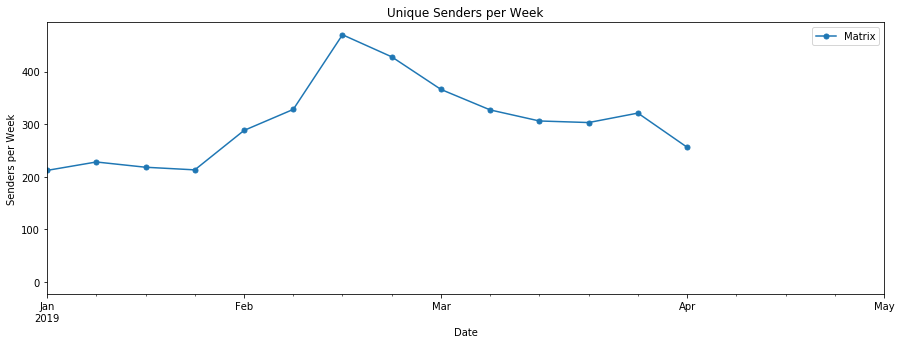

In [20]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Unique Senders per Week")
senders_per_week['matrix'].plot(ax=ax, label="Matrix", style="o-", ms=5)
ax.set_ylabel("Senders per Week")
ax.set_xlabel("Date")
lims = list(ax.axis())
print(lims)
lims[0] = 2558
lims[1] = 2575
ax.axis(lims)
_ = plt.legend()

[-19782.75, 19789.75, -8.700000000000001, 182.7]


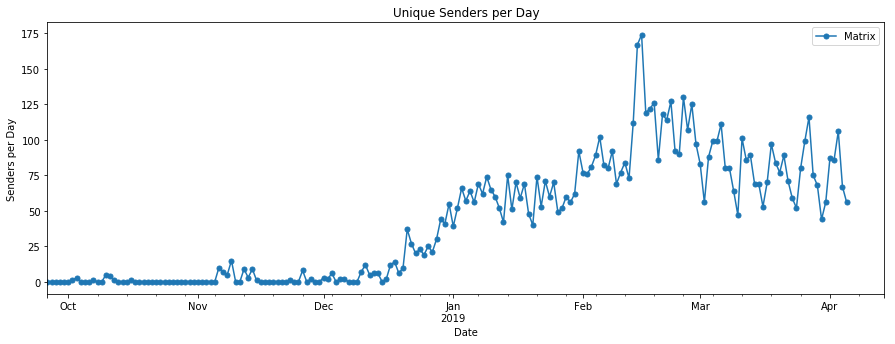

In [21]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Unique Senders per Day")
senders_per_day['matrix'].plot(ax=ax, label="Matrix", style="o-", ms=5)
ax.set_ylabel("Senders per Day")
ax.set_xlabel("Date")
lims = list(ax.axis())
print(lims)
lims[0] = 17800
lims[1] = 18000
ax.axis(lims)
_ = plt.legend()